In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-07-11 23:15:05.749625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 23:15:06.290625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-07-11 23:15:06.848784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 23:15:06.871347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 23:15:06.871524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2023-07-11 23:15:06.901431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 23:15:06.902530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 23:15:06.903176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-07-11 23:15:07.406659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 23:15:07.406842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 23:15:07.406961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [6]:
len(df_data)

5785

In [7]:
# df_cov = pd.read_csv(data_folder+'covsys_000.txt', sep='\\n')
# df_cov.head()

In [8]:
# cov = df_cov.values
# len(cov)

In [9]:
# cov = cov.reshape((len(df_data), len(df_data)))
# np.shape(cov)

In [10]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


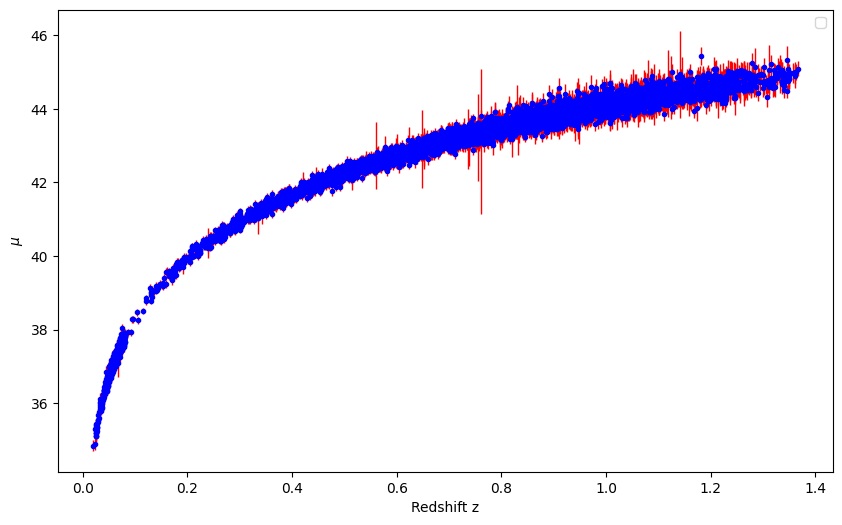

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [12]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [13]:
len(df_data)

5785

In [14]:
df_data.head()

,zCMB,MU,errors
0,0.01988,34.84680,0.13996
1,0.02321,34.89863,0.16230
2,0.02364,35.28915,0.13201
3,0.02470,35.11988,0.15157
4,0.02471,35.19347,0.13022


In [15]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [16]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.01988, 1.36643)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


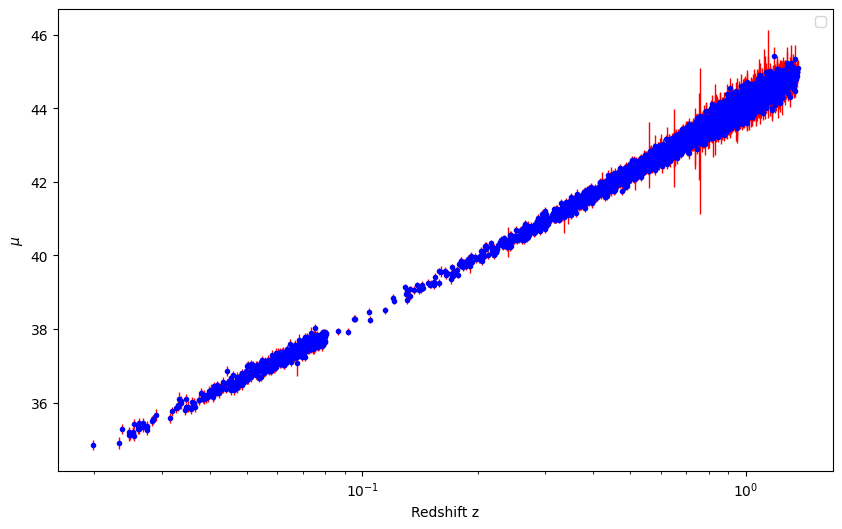

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [18]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [19]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [20]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [21]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((4630,), (4632,), (1157, 1), (1157, 1))

In [22]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 32
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,200,100])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 MCDropout_3 (MCDropout)     (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [23]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2000
145/145 [==============================] - 1s 2ms/step - loss: 872.1718 - val_loss: 803.3557
Epoch 2/2000
145/145 [==============================] - 0s 2ms/step - loss: 593.9598 - val_loss: 333.2239
Epoch 3/2000
145/145 [==============================] - 0s 2ms/step - loss: 201.1905 - val_loss: 140.9179
Epoch 4/2000
145/145 [==============================] - 0s 2ms/step - loss: 126.4518 - val_loss: 104.3118
Epoch 5/2000
145/145 [==============================] - 0s 2ms/step - loss: 94.4064 - val_loss: 82.3781
Epoch 6/2000
145/145 [==============================] - 0s 2ms/step - loss: 78.5849 - val_loss: 67.1160
Epoch 7/2000
145/145 [==============================] - 0s 2ms/step - loss: 66.0670 - val_loss: 57.1755
Epoch 8/2000
145/145 [==============================] - 0s 2ms/step - loss: 55.7548 - val_loss: 49.2655
Epoch 9/2000
145/145 [==============================] - 0s 2ms/step - loss: 50.9362 - val_loss: 47.3734
Epoch 10/2000
145/145 [==============================] -

145/145 [==============================] - 0s 2ms/step - loss: 20.2867 - val_loss: 19.5643
Epoch 80/2000
145/145 [==============================] - 0s 2ms/step - loss: 20.6032 - val_loss: 19.8583
Epoch 81/2000
145/145 [==============================] - 0s 2ms/step - loss: 19.7131 - val_loss: 21.2428
Epoch 82/2000
145/145 [==============================] - 0s 2ms/step - loss: 20.7488 - val_loss: 21.3243
Epoch 83/2000
145/145 [==============================] - 0s 2ms/step - loss: 21.1354 - val_loss: 19.6786
Epoch 84/2000
145/145 [==============================] - 0s 2ms/step - loss: 20.9138 - val_loss: 19.8278
Epoch 85/2000
145/145 [==============================] - 0s 2ms/step - loss: 20.0768 - val_loss: 21.3447
Epoch 86/2000
145/145 [==============================] - 0s 2ms/step - loss: 20.7265 - val_loss: 19.3747
Epoch 87/2000
145/145 [==============================] - 0s 2ms/step - loss: 21.5824 - val_loss: 21.3793
Epoch 88/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 18.0753 - val_loss: 18.2171
Epoch 234/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.6220 - val_loss: 16.9164
Epoch 235/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.2150 - val_loss: 16.8334
Epoch 236/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.3461 - val_loss: 16.2664
Epoch 237/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.1707 - val_loss: 18.1322
Epoch 238/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.5241 - val_loss: 17.6226
Epoch 239/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.2377 - val_loss: 18.2921
Epoch 240/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.7191 - val_loss: 17.4899
Epoch 241/2000
145/145 [==============================] - 0s 2ms/step - loss: 17.0674 - val_loss: 17.8161
Epoch 242/2000
145/145 [==============================] - 0s 

145/145 [==============================] - 0s 2ms/step - loss: 15.5804 - val_loss: 15.4295
Epoch 388/2000
145/145 [==============================] - 0s 2ms/step - loss: 15.8379 - val_loss: 14.8887
Epoch 389/2000
145/145 [==============================] - 0s 2ms/step - loss: 15.6951 - val_loss: 15.8828
Epoch 390/2000
145/145 [==============================] - 0s 2ms/step - loss: 15.0947 - val_loss: 15.7712
Epoch 391/2000
145/145 [==============================] - 0s 2ms/step - loss: 15.2979 - val_loss: 15.9117
Epoch 392/2000
145/145 [==============================] - 0s 2ms/step - loss: 15.3721 - val_loss: 14.7445
Epoch 393/2000
145/145 [==============================] - 0s 2ms/step - loss: 14.9491 - val_loss: 14.9674
Epoch 394/2000
145/145 [==============================] - 0s 2ms/step - loss: 15.4142 - val_loss: 15.5407
Epoch 395/2000
145/145 [==============================] - 0s 2ms/step - loss: 15.5504 - val_loss: 16.8601
Epoch 396/2000
145/145 [==============================] - 0s 

145/145 [==============================] - 0s 2ms/step - loss: 13.8413 - val_loss: 13.0596
Epoch 542/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.6658 - val_loss: 12.3472
Epoch 543/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.5475 - val_loss: 13.2026
Epoch 544/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.8089 - val_loss: 14.3308
Epoch 545/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.4152 - val_loss: 14.2120
Epoch 546/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.7265 - val_loss: 13.6387
Epoch 547/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.7188 - val_loss: 13.6984
Epoch 548/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.6630 - val_loss: 13.7413
Epoch 549/2000
145/145 [==============================] - 0s 2ms/step - loss: 13.2424 - val_loss: 12.7089
Epoch 550/2000
145/145 [==============================] - 0s 

145/145 [==============================] - 0s 2ms/step - loss: 11.8564 - val_loss: 12.1866
Epoch 696/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.3298 - val_loss: 12.3216
Epoch 697/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.1649 - val_loss: 12.2601
Epoch 698/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.2083 - val_loss: 12.8764
Epoch 699/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.3207 - val_loss: 11.6787
Epoch 700/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.1446 - val_loss: 12.7871
Epoch 701/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.3763 - val_loss: 11.2724
Epoch 702/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.2251 - val_loss: 11.6889
Epoch 703/2000
145/145 [==============================] - 0s 2ms/step - loss: 12.1305 - val_loss: 11.8422
Epoch 704/2000
145/145 [==============================] - 0s 

145/145 [==============================] - 0s 2ms/step - loss: 10.8138 - val_loss: 11.8052
Epoch 850/2000
145/145 [==============================] - 0s 2ms/step - loss: 11.2583 - val_loss: 10.6945
Epoch 851/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.8779 - val_loss: 10.7280
Epoch 852/2000
145/145 [==============================] - 0s 2ms/step - loss: 11.0482 - val_loss: 11.2880
Epoch 853/2000
145/145 [==============================] - 0s 2ms/step - loss: 11.3229 - val_loss: 10.9362
Epoch 854/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.8312 - val_loss: 10.8107
Epoch 855/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.8559 - val_loss: 10.7049
Epoch 856/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.3732 - val_loss: 10.8090
Epoch 857/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.5736 - val_loss: 10.7522
Epoch 858/2000
145/145 [==============================] - 0s 

145/145 [==============================] - 0s 2ms/step - loss: 9.7764 - val_loss: 10.0835
Epoch 1005/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.0233 - val_loss: 9.9101
Epoch 1006/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.0657 - val_loss: 9.8303
Epoch 1007/2000
145/145 [==============================] - 0s 2ms/step - loss: 9.8143 - val_loss: 8.9648
Epoch 1008/2000
145/145 [==============================] - 0s 2ms/step - loss: 9.8939 - val_loss: 9.5399
Epoch 1009/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.1826 - val_loss: 9.8212
Epoch 1010/2000
145/145 [==============================] - 0s 2ms/step - loss: 9.0995 - val_loss: 9.4868
Epoch 1011/2000
145/145 [==============================] - 0s 2ms/step - loss: 9.7172 - val_loss: 9.3549
Epoch 1012/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.0135 - val_loss: 10.1085
Epoch 1013/2000
145/145 [==============================] - 0s 2ms

145/145 [==============================] - 0s 2ms/step - loss: 9.0119 - val_loss: 8.4912
Epoch 1083/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.9409 - val_loss: 8.5970
Epoch 1084/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.9748 - val_loss: 8.7012
Epoch 1085/2000
145/145 [==============================] - 0s 2ms/step - loss: 9.0887 - val_loss: 8.3675
Epoch 1086/2000
145/145 [==============================] - 0s 2ms/step - loss: 9.0713 - val_loss: 9.2205
Epoch 1087/2000
145/145 [==============================] - 0s 2ms/step - loss: 9.0499 - val_loss: 9.5655
Epoch 1088/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.9676 - val_loss: 8.9428
Epoch 1089/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.9201 - val_loss: 9.3086
Epoch 1090/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.7661 - val_loss: 9.1762
Epoch 1091/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 7.8662 - val_loss: 7.8041
Epoch 1239/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.1255 - val_loss: 7.9450
Epoch 1240/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.7609 - val_loss: 8.1447
Epoch 1241/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.1552 - val_loss: 7.3816
Epoch 1242/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.3280 - val_loss: 7.8197
Epoch 1243/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.9822 - val_loss: 8.1951
Epoch 1244/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.0287 - val_loss: 7.6336
Epoch 1245/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.9830 - val_loss: 7.8365
Epoch 1246/2000
145/145 [==============================] - 0s 2ms/step - loss: 8.0009 - val_loss: 7.9359
Epoch 1247/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 7.2547 - val_loss: 7.4384
Epoch 1395/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.9956 - val_loss: 7.4158
Epoch 1396/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.2981 - val_loss: 7.5608
Epoch 1397/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.2726 - val_loss: 7.6545
Epoch 1398/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.6052 - val_loss: 7.7956
Epoch 1399/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.4918 - val_loss: 7.3720
Epoch 1400/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.4158 - val_loss: 6.9806
Epoch 1401/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.5365 - val_loss: 7.0009
Epoch 1402/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.4349 - val_loss: 7.7728
Epoch 1403/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 7.0764 - val_loss: 6.3091
Epoch 1551/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.7018 - val_loss: 6.8944
Epoch 1552/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.8835 - val_loss: 7.0459
Epoch 1553/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.9127 - val_loss: 6.8155
Epoch 1554/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.7503 - val_loss: 7.1405
Epoch 1555/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.7067 - val_loss: 6.8692
Epoch 1556/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.5163 - val_loss: 6.4220
Epoch 1557/2000
145/145 [==============================] - 0s 2ms/step - loss: 7.0900 - val_loss: 6.2677
Epoch 1558/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.8870 - val_loss: 6.8639
Epoch 1559/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 6.1710 - val_loss: 6.0546
Epoch 1707/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.3940 - val_loss: 6.2324
Epoch 1708/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.1946 - val_loss: 6.4369
Epoch 1709/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.1649 - val_loss: 5.8237
Epoch 1710/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.1358 - val_loss: 5.9144
Epoch 1711/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.2474 - val_loss: 6.2581
Epoch 1712/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.2811 - val_loss: 6.1237
Epoch 1713/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.2190 - val_loss: 5.9817
Epoch 1714/2000
145/145 [==============================] - 0s 2ms/step - loss: 6.2350 - val_loss: 6.7374
Epoch 1715/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 5.6896 - val_loss: 5.8154
Epoch 1863/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.6533 - val_loss: 5.6772
Epoch 1864/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.5157 - val_loss: 5.9173
Epoch 1865/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.7752 - val_loss: 6.1418
Epoch 1866/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.8052 - val_loss: 5.2160
Epoch 1867/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.6877 - val_loss: 5.6209
Epoch 1868/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.5286 - val_loss: 5.8726
Epoch 1869/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.5994 - val_loss: 5.1944
Epoch 1870/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.5212 - val_loss: 5.9165
Epoch 1871/2000
145/145 [==============================] - 0s 2ms/step 

In [24]:
model_train.history['val_loss'][-1]

5.429750442504883

(0.0, 50.0)

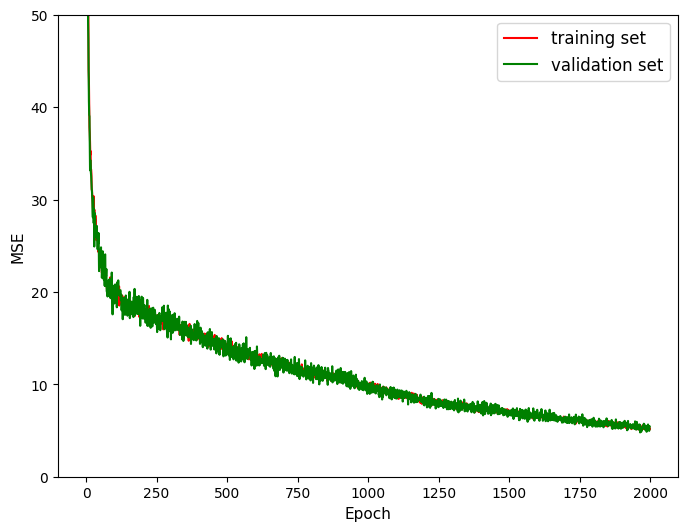

In [25]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 50)

In [26]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(zmin, zmax, test_batch_size)

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 898us/step


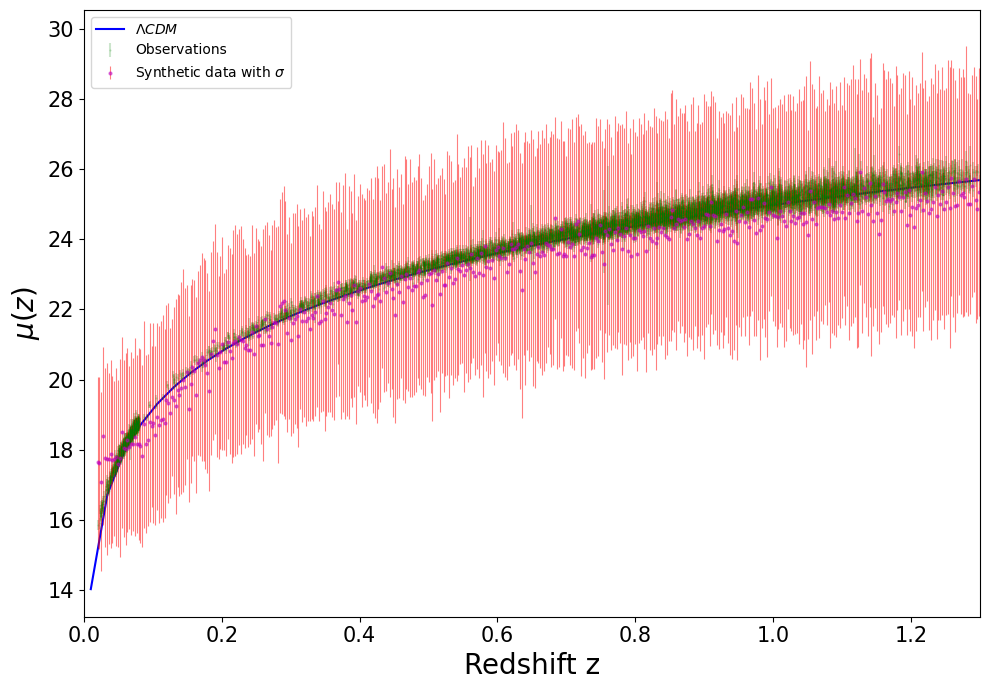

In [27]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors